# **Cats Vs Dogs Classification Using CNN with Data Augmentation**



### **Downloading Dataset From Kaggle (The tensorflow dataset is a subset of this kaggle dataset)**





In [1]:
# Install Kaggle API if not already installed
!pip install -q kaggle

# Upload kaggle.json (API key) - run this cell and upload your file when prompted
from google.colab import files
files.upload()  # Upload kaggle.json

# Move kaggle.json to the correct location and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### **Unzipping All the required files**

In [2]:
# Download the Dogs vs. Cats dataset from Kaggle
!kaggle competitions download -c dogs-vs-cats

# Unzip the main dataset
import os
from zipfile import ZipFile

def extract_zip(zip_path, extract_to):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Extract the main zip file
extract_zip('dogs-vs-cats.zip', 'dogs-vs-cats')

# Extract train and test zips inside the dogs-vs-cats folder
extract_zip('dogs-vs-cats/train.zip', 'dogs-vs-cats')
extract_zip('dogs-vs-cats/test1.zip', 'dogs-vs-cats')


100% 809M/812M [00:02<00:00, 258MB/s]
100% 812M/812M [00:02<00:00, 345MB/s]
Extracted dogs-vs-cats.zip to dogs-vs-cats
Extracted dogs-vs-cats/train.zip to dogs-vs-cats
Extracted dogs-vs-cats/test1.zip to dogs-vs-cats


### **Counting Total Number of files in train and test**

In [3]:
import os

train_dir = 'dogs-vs-cats/train'
test_dir = 'dogs-vs-cats/test1'

train_images = os.listdir(train_dir)
test_images = os.listdir(test_dir)

print(f"Total number of training images: {len(train_images)}")
print(f"Total number of test images: {len(test_images)}")

print(f"Sample training file names: {train_images[:5]}")
print(f"Sample test file names: {test_images[:5]}")


Total number of training images: 25000
Total number of test images: 12500
Sample training file names: ['cat.1416.jpg', 'dog.6488.jpg', 'dog.431.jpg', 'dog.1586.jpg', 'dog.7724.jpg']
Sample test file names: ['5225.jpg', '8580.jpg', '8742.jpg', '9579.jpg', '8382.jpg']


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random


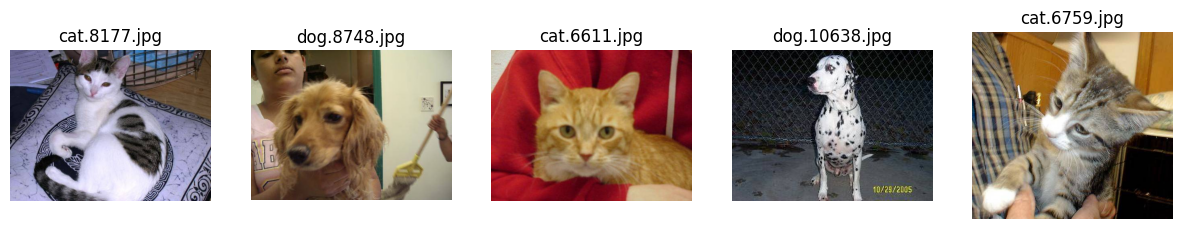

In [5]:
# Display a few random training images
sample_files = random.sample(train_images, 5)
plt.figure(figsize=(15,5))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(train_dir, fname)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
plt.show()


### **Moving Cats and Dogs Images To separate Directories inside Train**

In [6]:
import os
import shutil

train_dir = 'dogs-vs-cats/train'
cat_dir = os.path.join(train_dir, 'cat')
dog_dir = os.path.join(train_dir, 'dog')

# Create directories if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move images to respective folders
for fname in os.listdir(train_dir):
    fpath = os.path.join(train_dir, fname)
    # Skip directories (including 'cat' and 'dog' themselves)
    if os.path.isdir(fpath):
        continue
    if fname.startswith('cat'):
        shutil.move(fpath, os.path.join(cat_dir, fname))
    elif fname.startswith('dog'):
        shutil.move(fpath, os.path.join(dog_dir, fname))


# **CNN From Scratch**

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
img_height, img_width = 150, 150
batch_size = 32

# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'dogs-vs-cats/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'dogs-vs-cats/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 284ms/step - accuracy: 0.5395 - loss: 0.7102 - val_accuracy: 0.6118 - val_loss: 0.6705
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 326ms/step - accuracy: 0.6824 - loss: 0.5931 - val_accuracy: 0.7466 - val_loss: 0.5146
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 177s 283ms/step - accuracy: 0.7659 - loss: 0.4875 - val_accuracy: 0.7812 - val_loss: 0.4711
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 318ms/step - accuracy: 0.7963 - loss: 0.4354 - val_accuracy: 0.8069 - val_loss: 0.4231
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 320ms/step - accuracy: 0.8210 - loss: 0.3872 - val_accuracy: 0.8269 - val_loss: 0.3903
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 175s 279ms/step - accuracy: 0.8318 - loss: 0.3704 - val_accuracy: 0.8287 - val_loss: 0.3991
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 270ms/step - accuracy: 0.8446 - loss: 0.3538 - val_accuracy: 0.8347 - val_loss: 0.3652
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 271ms/step - accuracy: 0.8642 -

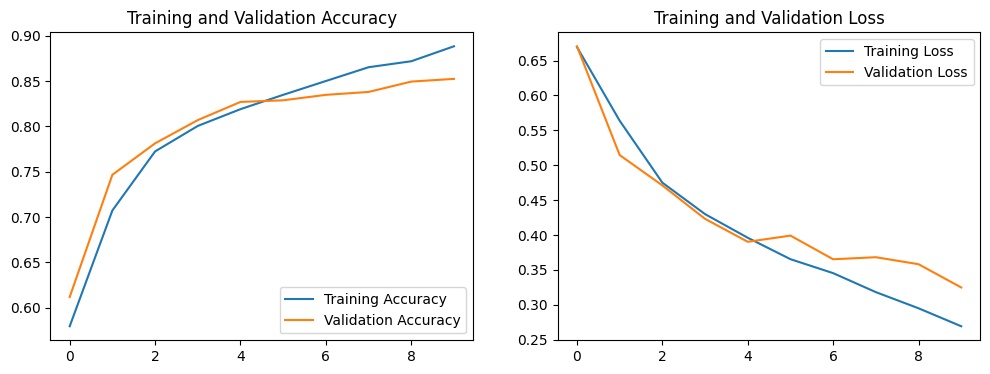

In [10]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


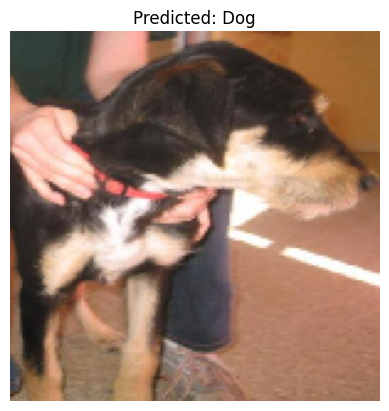

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


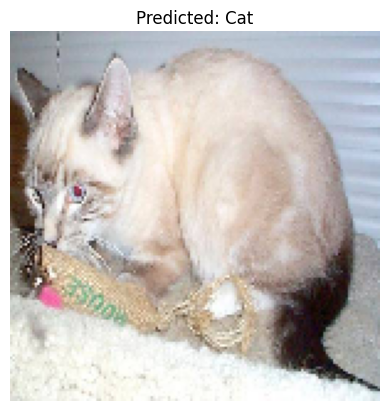

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


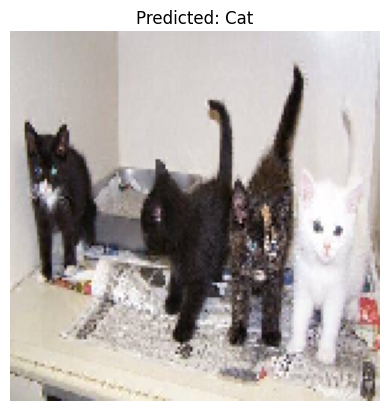

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


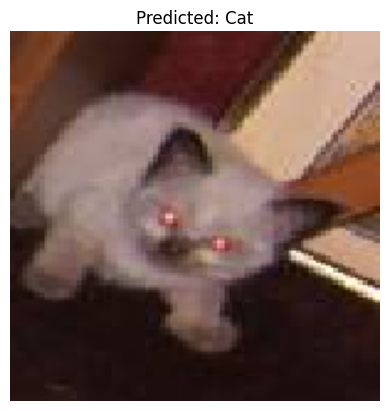

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


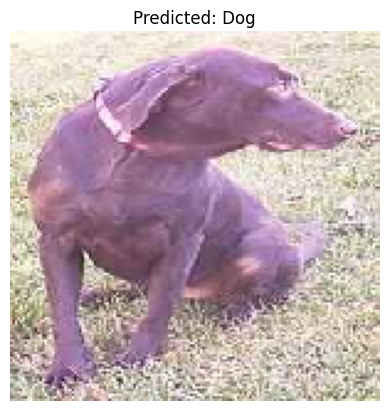

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

test_dir = 'dogs-vs-cats/test1'
test_images = os.listdir(test_dir)

# Predict on a few test images
for img_name in test_images[:5]:
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    label = 'Dog' if prediction[0][0] > 0.5 else 'Cat'
    plt.imshow(img)
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()


In [12]:
(test_loss, test_acc) = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.8546 - loss: 0.3299
Test accuracy: 0.8624
Test loss: 0.3213


Saving manja-vitolic-gKXKBY-C-Dk-unsplash.jpg to manja-vitolic-gKXKBY-C-Dk-unsplash.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


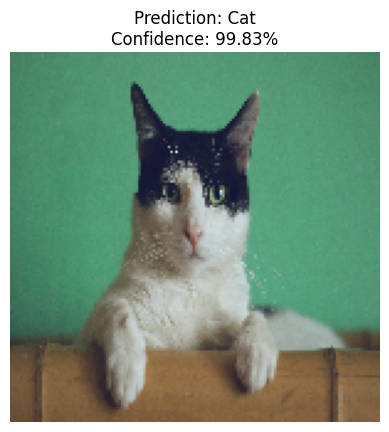

Prediction: Cat, Confidence: 99.83%


In [13]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload an image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)[0][0]
    label = 'Dog' if pred > 0.5 else 'Cat'
    confidence = pred if pred > 0.5 else 1 - pred

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {label}\nConfidence: {confidence:.2%}')
    plt.show()
    print(f"Prediction: {label}, Confidence: {confidence:.2%}")


In [14]:
model.save('content/scratch_model_kaggle.h5')

# **Using Pretrained Model MobileNetV2**

---



In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
IMG_SIZE = (224, 224)  # MobileNetV2 expects 224x224 images

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    'dogs-vs-cats/train',          # Path to your train folder
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'dogs-vs-cats/train',          # Same folder, but using validation split
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [17]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base

model_pretrained = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model_pretrained.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
model_pretrained.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
history_pretrained = model_pretrained.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 337s 523ms/step - accuracy: 0.9300 - loss: 0.1682 - val_accuracy: 0.9748 - val_loss: 0.0661
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 309s 495ms/step - accuracy: 0.9748 - loss: 0.0633 - val_accuracy: 0.9750 - val_loss: 0.0610
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 308s 492ms/step - accuracy: 0.9746 - loss: 0.0634 - val_accuracy: 0.9770 - val_loss: 0.0599
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 309s 494ms/step - accuracy: 0.9779 - loss: 0.0556 - val_accuracy: 0.9754 - val_loss: 0.0681
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 328s 525ms/step - accuracy: 0.9789 - loss: 0.0505 - val_accuracy: 0.9770 - val_loss: 0.0601


In [20]:
model_pretrained.save('content/pretrained_model_kaggle.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


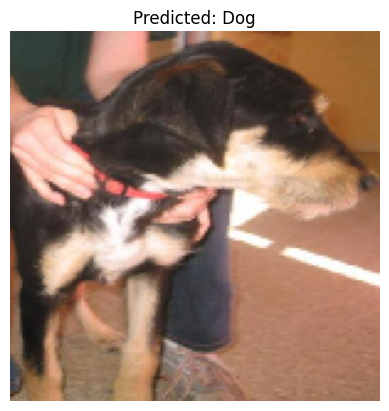

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


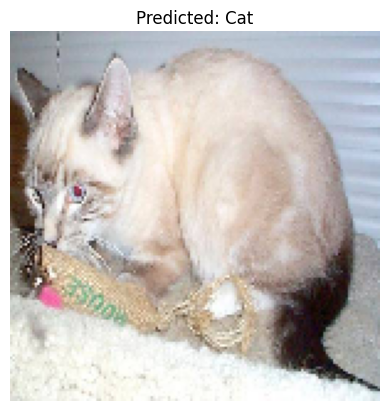

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


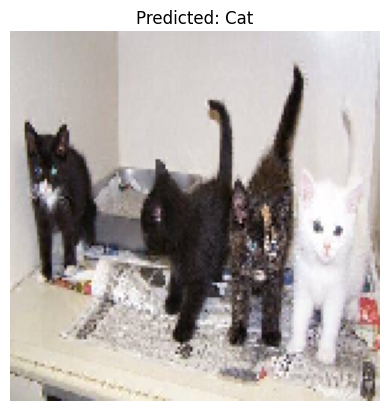

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


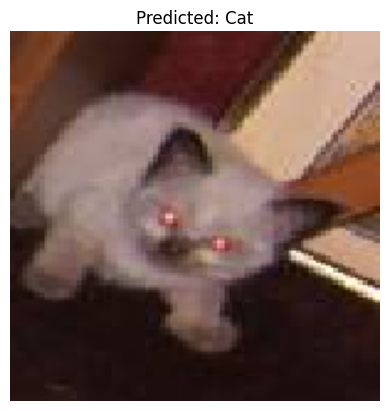

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


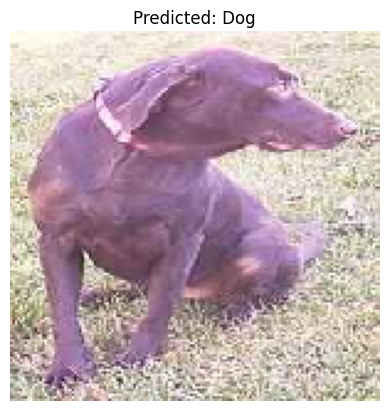

In [22]:
import numpy as np
from tensorflow.keras.preprocessing import image

test_dir = 'dogs-vs-cats/test1'
test_images = os.listdir(test_dir)

# Predict on a few test images
for img_name in test_images[:5]:
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model_pretrained.predict(img_array)
    label = 'Dog' if prediction[0][0] > 0.5 else 'Cat'
    plt.imshow(img)
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()


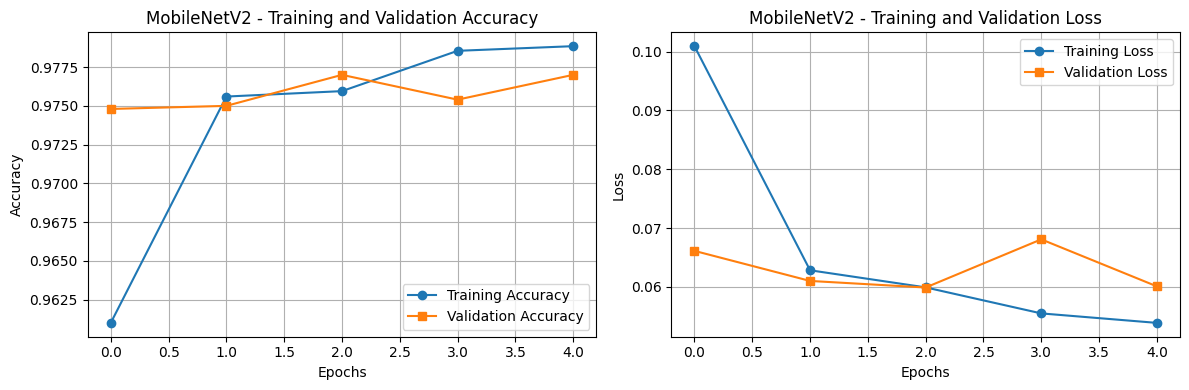

Final Training Accuracy: 0.9789
Final Validation Accuracy: 0.9770
Final Training Loss: 0.0539
Final Validation Loss: 0.0601


In [23]:
import matplotlib.pyplot as plt

# Extract training history
acc = history_pretrained.history['accuracy']
val_acc = history_pretrained.history['val_accuracy']
loss = history_pretrained.history['loss']
val_loss = history_pretrained.history['val_loss']

epochs_range = range(len(acc))

# Create subplots
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.legend(loc='lower right')
plt.title('MobileNetV2 - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
plt.legend(loc='upper right')
plt.title('MobileNetV2 - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Saving manja-vitolic-gKXKBY-C-Dk-unsplash.jpg to manja-vitolic-gKXKBY-C-Dk-unsplash (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


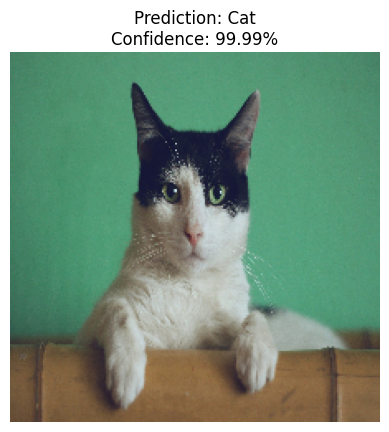

Prediction: Cat, Confidence: 99.99%


In [31]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    img = image.load_img(fn, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_pretrained.predict(img_array)[0][0]
    label = 'Dog' if pred > 0.5 else 'Cat'
    confidence = pred if pred > 0.5 else 1 - pred
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {label}\nConfidence: {confidence:.2%}')
    plt.show()
    print(f"Prediction: {label}, Confidence: {confidence:.2%}")